In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/energydata_complete.csv',index_col=0,parse_dates=True,infer_datetime_format=True)
df.head()

/tmp/ipython-input-759893216.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('/content/drive/MyDrive/energydata_complete.csv',index_col=0,parse_dates=True,infer_datetime_format=True)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
df.shape

(19735, 28)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 11-01-2016 17:00 to 27-05-2016 18:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 non-nu

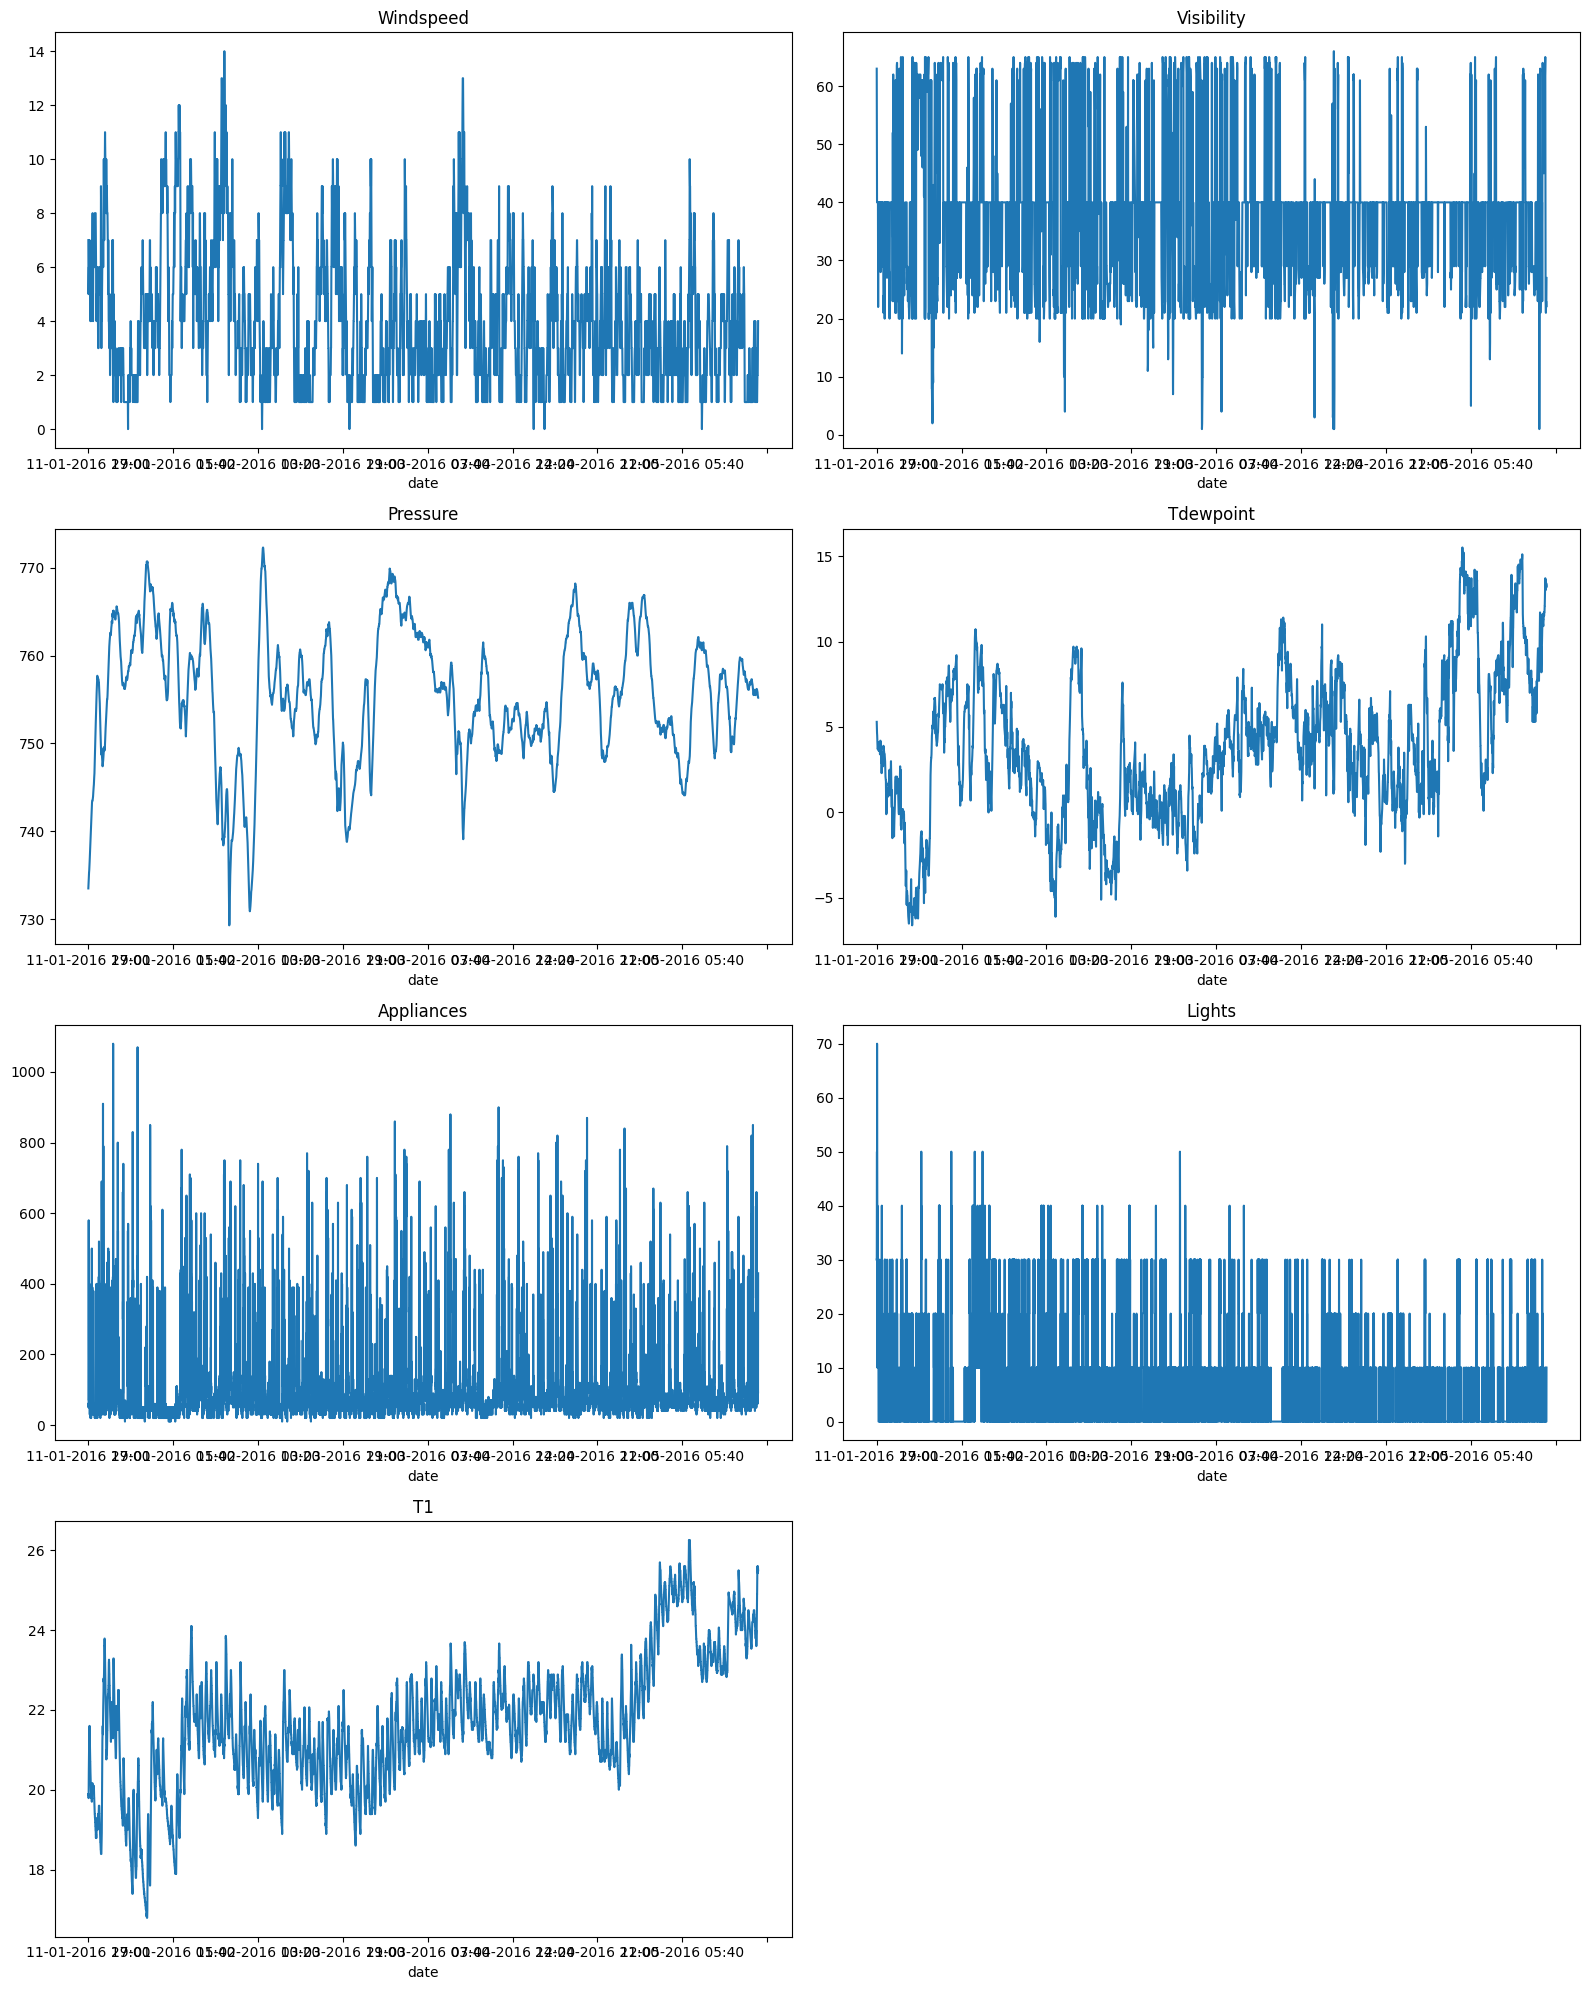

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20)) # Adjust figsize as needed for better visibility

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature on a separate subplot
df['Windspeed'].plot(ax=axes[0])
axes[0].set_title('Windspeed')

df['Visibility'].plot(ax=axes[1])
axes[1].set_title('Visibility')

df['Press_mm_hg'].plot(ax=axes[2])
axes[2].set_title('Pressure')

df['Tdewpoint'].plot(ax=axes[3])
axes[3].set_title('Tdewpoint')

df['Appliances'].plot(ax=axes[4])
axes[4].set_title('Appliances')

df['lights'].plot(ax=axes[5])
axes[5].set_title('Lights')

df['T1'].plot(ax=axes[6])
axes[6].set_title('T1')

# Hide any unused subplots (in this case, the last one)
axes[7].axis('off')

# Adjust layout to prevent titles from overlapping
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
df = df.round(2)
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
11-01-2016 17:00,60,30,19.89,47.60,19.2,44.79,19.79,44.73,19.00,45.57,...,17.03,45.53,6.60,733.5,92.0,7.00,63.00,5.3,13.28,13.28
11-01-2016 17:10,60,30,19.89,46.69,19.2,44.72,19.79,44.79,19.00,45.99,...,17.07,45.56,6.48,733.6,92.0,6.67,59.17,5.2,18.61,18.61
11-01-2016 17:20,50,30,19.89,46.30,19.2,44.63,19.79,44.93,18.93,45.89,...,17.00,45.50,6.37,733.7,92.0,6.33,55.33,5.1,28.64,28.64
11-01-2016 17:30,50,40,19.89,46.07,19.2,44.59,19.79,45.00,18.89,45.72,...,17.00,45.40,6.25,733.8,92.0,6.00,51.50,5.0,45.41,45.41
11-01-2016 17:40,60,40,19.89,46.33,19.2,44.53,19.79,45.00,18.89,45.53,...,17.00,45.40,6.13,733.9,92.0,5.67,47.67,4.9,10.08,10.08


In [ ]:
test_size = 30 * 144 # 30 days / 1 month

train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

In [ ]:
train.shape, test.shape

((15415, 28), (4320, 28))

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [ ]:
length = 288
batch_size = 16

train_generator = TimeseriesGenerator(data=scaled_train,targets=scaled_train,length=length,batch_size=batch_size)
train_generator

In [ ]:
len(train_generator)

946

In [ ]:
X, y = train_generator[0]
X.shape, y.shape

((16, 288, 28), (16, 28))

In [ ]:
validation_generator = TimeseriesGenerator(data=scaled_test,targets=scaled_test,length=length,batch_size=batch_size)
validation_generator

In [ ]:
model = Sequential()
model.add(LSTM(units=150,activation='relu',input_shape=(length,scaled_train.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(units=scaled_train.shape[1]))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │       107,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │         4,228 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,628 (436.05 KB)

 Trainable params: 111,628 (436.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='mse',optimizer='adam')
es = EarlyStopping(monitor='val_loss',mode='min',patience=2,restore_best_weights=True,start_from_epoch=6,verbose=1)
es


In [ ]:
model.fit(x=train_generator,
          epochs=10,
          validation_data=validation_generator,
          callbacks=[es])


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


946/946 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.0350 - val_loss: 0.0142
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.0133 - val_loss: 0.0114
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.0102 - val_loss: 0.0112
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.0098 - val_loss: 0.0106
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.0096 - val_loss: 0.0109
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 9/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 10/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.0092 - val_loss: 0.0087
Restoring model weights from the end of the best epoch: 10.


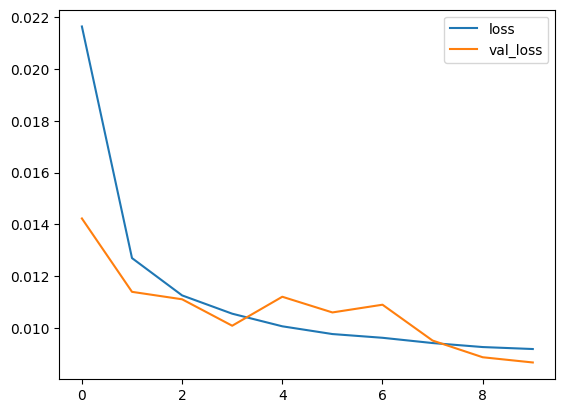

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot();

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,scaled_train.shape[1]))

for i in tqdm(range(len(test))):
    pred = model.predict(current_batch,verbose=0)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

test_predictions[:5]

  0%|          | 0/4320 [00:00<?, ?it/s]

[array([0.15421483, 0.04912341, 0.59068114, 0.22698197, 0.38276452,
        0.34301862, 0.39441803, 0.11654927, 0.5947699 , 0.25897032,
        0.5008201 , 0.09461976, 0.4579885 , 0.3821809 , 0.52854145,
        0.1899589 , 0.7036697 , 0.25730738, 0.45059785, 0.1554419 ,
        0.4512336 , 0.6177809 , 0.5286505 , 0.2560512 , 0.58955   ,
        0.38880554, 0.49366683, 0.49151024], dtype=float32),
 array([0.10815219, 0.04662076, 0.58048004, 0.22570987, 0.37146288,
        0.34557685, 0.38617927, 0.1227131 , 0.5777732 , 0.25651327,
        0.48866892, 0.10825649, 0.44129905, 0.37364602, 0.5139952 ,
        0.17462398, 0.68204975, 0.24948764, 0.44350225, 0.15986568,
        0.43710655, 0.62286425, 0.5213178 , 0.25830418, 0.5608231 ,
        0.37021002, 0.48284578, 0.4805017 ], dtype=float32),
 array([0.08642107, 0.04897792, 0.5790959 , 0.22361252, 0.36573732,
        0.3485502 , 0.3837747 , 0.12434064, 0.57216537, 0.25648087,
        0.48509154, 0.11703269, 0.43468335, 0.3732034 , 0.5075

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[ 1.75009867e+02,  3.43863845e+00,  2.11078791e+01, ...,
         3.98499691e-01,  2.46884047e+01,  2.45805970e+01],
       [ 1.25722842e+02,  3.26345295e+00,  2.10333091e+01, ...,
         6.37803912e-02,  2.41474607e+01,  2.40302806e+01],
       [ 1.02470540e+02,  3.42845406e+00,  2.10231910e+01, ...,
         2.88580298e-02,  2.39632670e+01,  2.38440488e+01],
       ...,
       [ 8.42994843e+01,  3.97110641e+00,  1.92749887e+01, ...,
        -2.18310235e+00,  2.40463542e+01,  2.39982286e+01],
       [ 8.42994684e+01,  3.97110589e+00,  1.92749887e+01, ...,
        -2.18310235e+00,  2.40463542e+01,  2.39982286e+01],
       [ 8.42994684e+01,  3.97110589e+00,  1.92749887e+01, ...,
        -2.18310235e+00,  2.40463542e+01,  2.39982286e+01]])

In [ ]:
true_predictions = pd.DataFrame(true_predictions,columns=test.columns)
true_predictions

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,175.009867,3.438638,21.107879,35.817368,19.353498,36.143174,21.301948,34.673109,20.250707,33.727675,...,18.922851,34.496354,6.145470,755.864580,67.476886,3.584717,39.320751,0.398500,24.688405,24.580597
1,125.722842,3.263453,21.033309,35.772043,19.257434,36.220611,21.216264,34.781161,20.103516,33.670106,...,18.859345,34.595005,5.796532,756.083163,66.970927,3.616259,37.453500,0.063780,24.147461,24.030281
2,102.470540,3.428454,21.023191,35.697314,19.208767,36.310615,21.191257,34.809691,20.054952,33.669347,...,18.864636,34.793711,5.642648,756.365920,67.381611,3.653952,36.391585,0.028858,23.963267,23.844049
3,88.119733,3.630404,21.039489,35.633800,19.184738,36.398320,21.189811,34.817786,20.050616,33.695763,...,18.888715,35.000552,5.537262,756.747651,68.089052,3.673042,35.835177,0.075995,23.902739,23.783783
4,77.570703,3.766059,21.062740,35.571876,19.166715,36.473693,21.195374,34.816595,20.064196,33.717089,...,18.916090,35.188070,5.424935,757.218410,68.913139,3.670729,35.579683,0.128171,23.902262,23.784347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,84.299476,3.971106,19.274989,36.365097,17.933871,36.552544,19.214729,36.664974,17.750170,35.251564,...,16.928535,37.548194,2.154032,762.565307,73.711112,1.482911,30.315979,-2.183102,24.046354,23.998229
4316,84.299476,3.971106,19.274989,36.365097,17.933871,36.552544,19.214729,36.664974,17.750170,35.251564,...,16.928535,37.548194,2.154032,762.565307,73.711112,1.482911,30.315979,-2.183102,24.046354,23.998229
4317,84.299484,3.971106,19.274989,36.365097,17.933871,36.552544,19.214729,36.664974,17.750170,35.251564,...,16.928535,37.548194,2.154032,762.565307,73.711112,1.482911,30.315979,-2.183102,24.046354,23.998229
4318,84.299468,3.971106,19.274989,36.365097,17.933871,36.552544,19.214729,36.664974,17.750170,35.251564,...,16.928535,37.548194,2.154032,762.565307,73.711112,1.482911,30.315979,-2.183102,24.046354,23.998229


In [ ]:
rmse_scores = []

for col in test.columns:
    rmse_scores.append(np.sqrt(mean_squared_error(test[col],true_predictions[col])))

print("Mean RMSE Score:", round(np.mean(rmse_scores),5))

Mean RMSE Score: 12.71124


In [ ]:
import joblib

# Save model
joblib.dump(model, "energy_model.pkl")

# Load model later
loaded_model = joblib.load("energy_model.pkl")


In [ ]:
from google.colab import files
files.download("energy_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>